# Inotroduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Alternative base learners: gbtree, gblinear and dart

</font>
</div>

# Theoretical recall
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- **Tree-based** models allow to represent all types of non-linear data well, since no formula is needed which describes the relation between target and input variables. This is an enormous advantage if these relations and interactions are unknown. 
- **Linear** models on the other hand cannot learn other relations than pure linear ones. If these additional interactions can be supplied, linear models become quite powerful. 
- The second aspect considered the fact that the **training data does not always cover the full data range** of the use case. Here, the model needs to inter- or extrapolate from known datapoints to the new regions. In the case of trees, no formula is available, which would allow to navigate these areas and provide meaningful prediction values. In contrast, this is the main advantage of linear regression models – if the same assumptions can be applied to the new data. In other words, if the new data behaves in the same way.

</font>
</div>

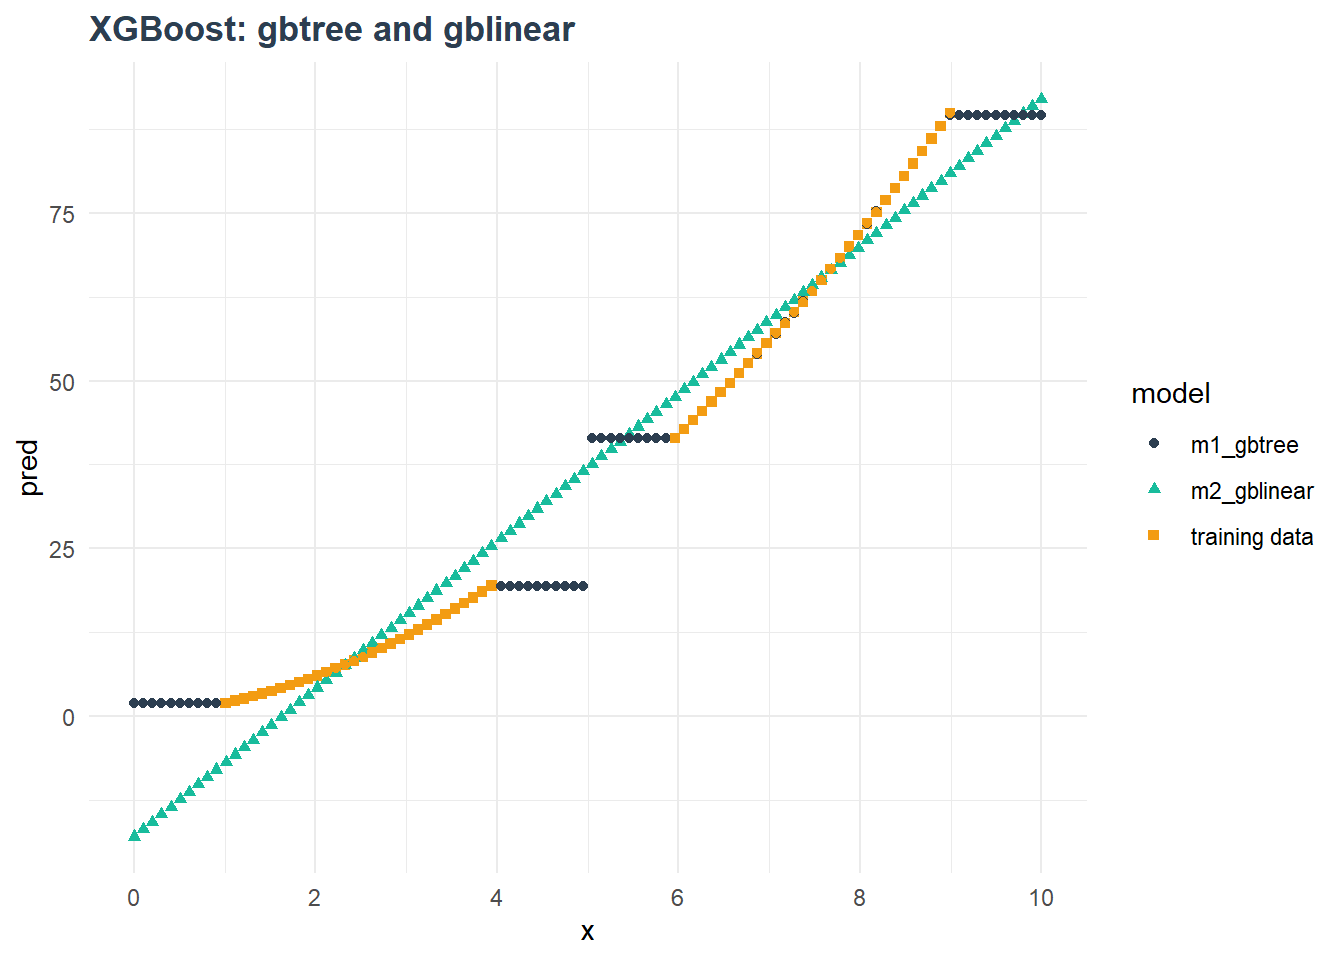

# Import modules
<hr style = "border:2px solid black" ></hr>

In [17]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor, XGBClassifier, XGBRFRegressor, XGBRFClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from pylab import rcParams
from matplotlib import pyplot

# Load dataset
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- The Diabetes dataset is a regression dataset of 442 diabetes patients provided by scikit-learn. 
- The prediction columns include age, sex, BMI (body mass index), BP (blood pressure), and five serum measurements. 
- The target column is the progression of the disease after 1 year.

</font>
</div>

In [2]:
X, y = load_diabetes(return_X_y=True)

# Applying gblinear
<hr style = "border:2px solid black" ></hr>

In [3]:
kfold = KFold(n_splits=5, shuffle=True, random_state=2)

In [4]:
def regression_model(model):
    # Obtain scores of cross-validation using 10 splits and mean squared error
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold)

    # Take square root of the scores
    rmse = (-scores)**0.5

    # Return mean score
    return rmse.mean()

In [5]:
regression_model(XGBRegressor(booster='gblinear', objective='reg:squarederror'))

55.501336939001

<div class="alert alert-info">
<font color=black>

- Let's check this score against other linear models including LinearRegression, Lasso, which uses L1 or absolute 
value regularization, and Ridge, which uses L2 or Euclidean distance regularization.  

</font>
</div>

In [6]:
regression_model(LinearRegression())

55.50927267834351

In [7]:
regression_model(Lasso())

62.64900771743497

In [8]:
regression_model(Ridge())

58.83525077919003

In [9]:
regression_model(XGBRegressor(booster='gbtree', objective='reg:squarederror'))

65.96608419624594

<div class="alert alert-info">
<font color=black>

- As you can see, the gbtree base learner does not perform nearly as well as the gblinear base learner in this case indicating that a linear model is ideal. 
- Let's see if we can modify hyperparameters to make some gains with gblinear as the base learner.

</font>
</div>

In [9]:
def grid_search(params, reg=XGBRegressor(booster='gblinear', objective='reg:squarederror')):

    # Instantiate GridSearchCV as grid_reg
    grid_reg = GridSearchCV(reg, params, scoring='neg_mean_squared_error', cv=kfold)
    
    # Fit grid_reg on X_train and y_train
    grid_reg.fit(X, y)

    # Extract best params
    best_params = grid_reg.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = np.sqrt(-grid_reg.best_score_)

    # Print best score
    print("Best score:", best_score)

In [10]:
grid_search(params={'reg_alpha':[0.001, 0.01, 0.1, 0.5, 1, 5]})

Best params: {'reg_alpha': 0.01}
Best score: 55.48581402713292


In [11]:
grid_search(params={'reg_lambda':[0.001, 0.01, 0.1, 0.5, 1, 5]})

Best params: {'reg_lambda': 0.001}
Best score: 56.17163510650395


In [12]:
grid_search(params={'feature_selector':['shuffle']})

Best params: {'feature_selector': 'shuffle'}
Best score: 55.549663034498025


In [13]:
grid_search(params={'feature_selector':['random', 'greedy', 'thrifty'], 'updater':['coord_descent'] })

Best params: {'feature_selector': 'thrifty', 'updater': 'coord_descent'}
Best score: 55.48798105805444


In [14]:
grid_search(params={'feature_selector':['greedy', 'thrifty'], 'updater':['coord_descent'], 'top_k':[3, 5, 7, 9]})

Best params: {'feature_selector': 'thrifty', 'top_k': 3, 'updater': 'coord_descent'}
Best score: 55.478623763746256


<div class="alert alert-info">
<font color=black>

- Now let's see how gblinear works on a dataset that is linear by construction.

</font>
</div>

In [15]:
X = np.arange(1,100)
np.random.seed(2) 
y = []
for i in X:
    y.append(i*np.random.uniform(-0.2, 0.2))
y = np.array(y)
X = X.reshape(X.shape[0], 1)
y = y.reshape(y.shape[0], 1)

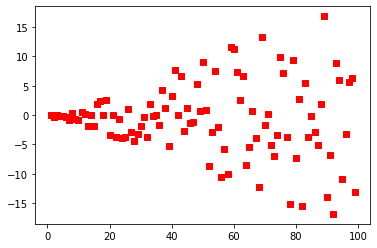

In [18]:
pyplot.plot(X, y, "rs")

In [19]:
regression_model(XGBRegressor(booster='gblinear', objective='reg:squarederror'))

6.214946302686011

In [20]:
regression_model(XGBRegressor(booster='gbtree', objective='reg:squarederror'))

9.37235946501318

In [21]:
regression_model(LinearRegression())

6.214962315808842

In [22]:
X, y = load_diabetes(return_X_y=True)

<div class="alert alert-info">
<font color=black>

- In this case, gblinear performs slightly better, perhaps negligibly, scoring 0.00002 points lower than LinearRegression. 

</font>
</div>

# Applying DART
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- The base learner dart is similar to gbtree in the sense that both are gradient boosted trees. 
- The primary difference is that dart removes trees (called dropout) during each round of boosting.

</font>
</div>

In [23]:
regression_model(XGBRegressor(booster='dart', objective='reg:squarederror'))

65.96444746130739

In [24]:
df_census = pd.read_csv('../DATASETS/census_cleaned.csv')
X_census = df_census.iloc[:, :-1]
y_census = df_census.iloc[:, -1]

In [25]:
def classification_model(model):
    # Obtain scores of cross-validation using 10 splits and mean squared error
    scores = cross_val_score(model, X_census, y_census, scoring='accuracy', cv=kfold)

    # Return mean score
    return scores.mean()

In [26]:
classification_model(XGBClassifier(booster='gbtree'))

0.8701208195968675

In [27]:
classification_model(XGBClassifier(booster='dart'))

0.8701208195968675

In [34]:
classification_model(XGBClassifier(booster='gblinear'))

0.8502504158192782

In [35]:
classification_model(LogisticRegression(max_iter=1000))

0.7968120977851517

In [36]:
classification_model(XGBClassifier(booster='dart', one_drop=1))

0.8718714338474818

In [37]:
regression_model(XGBRegressor(booster='dart', objective='reg:squarederror', sample_type='weighted'))

65.96444746130739

In [38]:
regression_model(XGBRegressor(booster='dart', objective='reg:squarederror', normalize_type='forest'))

65.96444746130739

In [39]:
regression_model(XGBRegressor(booster='dart', objective='reg:squarederror', one_drop=1))

61.81275131335009

In [40]:
grid_search(params={'rate_drop':[0.01, 0.1, 0.2, 0.4]}, 
            reg=XGBRegressor(booster='dart', objective='reg:squarederror', one_drop=1))

Best params: {'rate_drop': 0.2}
Best score: 61.07249602732062


In [41]:
grid_search(params={'skip_drop': [0.01, 0.1, 0.2, 0.4]}, 
            reg=XGBRegressor(booster='dart', objective='reg:squarederror', one_drop=1))

Best params: {'skip_drop': 0.1}
Best score: 62.879753748627635


<div class="alert alert-info">
<font color=black>

- DART provides a compelling option within the XGBoost framework. 
- Since dart accepts all gbtree hyperparameters, it's easy to change the base learner from gbtree to dart when modifying hyperparameters. 
- In effect, the advantage is that you can experiment with new hyperparameters including one_drop, rate_drop, normalize, and others to see if you can make additional gains. 
- DART is definitely worth trying as a base learner in your research and model-building with XGBoost.

</font>
</div>

In [42]:
regression_model(XGBRegressor(booster='gbtree', objective='reg:squarederror', num_parallel_tree=25))

65.96604877151103

In [43]:
regression_model(XGBRegressor(booster='gbtree', objective='reg:squarederror', num_parallel_tree=5))

65.96445649315855

<div class="alert alert-info">
<font color=black>

- There is not an option to set the booster hyperparameter to a random forest. 
- Instead, the hyperparameter num_parallel_tree may be increased from its default value of 1 to transform gbtree (or dart) into a boosted random forest. 
- The idea here is that each boosting round will no longer consist of one tree, but a number of parallel trees, which in turn make up a forest”

</font>
</div>

In [44]:
regression_model(XGBRFRegressor(objective='reg:squarederror'))

59.447250741400595

In [45]:
regression_model(RandomForestRegressor())

59.46563031802505

In [46]:
classification_model(XGBRFClassifier())

0.856085650471878

In [47]:
classification_model(RandomForestClassifier())

0.8555328202034789

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- Hands-On Gradient Boosting with XGBoost and scikit-learn
- https://www.avato-consulting.com/?p=28903&lang=en
- https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn
    
</font>
</div>